# Study D
This notebook shows the full workflow for building models, simulating growth and obtaining SCFA predictions from data collected by the Gut Puzzle project in the Gibbons Lab, 2023

In [2]:
import pandas as pd
import numpy as np 
import scipy
import micom
import micom.measures
from plotnine import *

import os
%matplotlib inline

## Flux Calculation
Here we will calculate production rate from the experimental SCFA measurements and convert them to dicts for later use

In [352]:
scfas = pd.read_csv('/users/nbohmann/exvivo/gut_puzzle/scfas_batch1.csv')
scfas = scfas[scfas['Sample Description'].isin(['baseline','PBS', 'inulin', 'pectin'])]
scfas = scfas[scfas['Analyte'].isin(['Acetic acid', 'Butyric acid', 'Propionic acid'])]
scfas['Analyte'] = scfas['Analyte'].str.replace('ic acid', 'ate')
scfas['Sample Description'] = scfas['Sample Description'].str.replace('PBS','control')
scfas = scfas.rename(columns = {'Client Sample ID':'sample_id',
                                'Sample Description':'treatment',
                                'Analyte':'analyte',
                                'Result':'flux'})
scfas = scfas[['donor_id','treatment','analyte','flux']]
grouped = scfas.groupby(['donor_id', 'analyte'])
analyteBaseline = grouped.apply(lambda group: group[group['treatment'] == 'baseline']['flux'].mean()).reset_index()
scfas = pd.merge(scfas, analyteBaseline, on=['donor_id', 'analyte'])
scfas.rename(columns = {0:'flux_baseline'}, inplace = True)
scfas['flux'] = scfas['flux'] - scfas['flux_baseline']
baselinePPA = scfas[(scfas['treatment'] == 'baseline')&(scfas['analyte'] == 'Propionate')]
baselineBUT = scfas[(scfas['treatment'] == 'baseline')&(scfas['analyte'] == 'Butyrate')]
baselinePPA = baselinePPA.groupby(['donor_id'])['flux_baseline'].mean().to_dict()
baselineBUT = baselineBUT.groupby(['donor_id'])['flux_baseline'].mean().to_dict()
scfas = scfas[scfas['treatment'] != 'baseline']
scfas = scfas.drop(columns=['flux_baseline'])
scfas['sample_id'] = scfas['donor_id'].astype('str')+'_'+scfas['treatment']
shannon = pd.read_csv('/proj/gibbons/nbohmann/exvivo/gut_puzzle/shannon/alpha-diversity.tsv',
                      sep = '\t', index_col = 0)
shannon = shannon['shannon_entropy'].to_dict()
scfas['shannon'] = scfas['donor_id'].map(shannon)
semMeasured = scfas.groupby(['sample_id','donor_id','treatment','analyte']).sem().reset_index()
semMeasured = pd.pivot(semMeasured, 
                       index = 'sample_id', 
                       columns = 'analyte',
                       values = 'flux')
semMeasured.rename(columns = {'Acetate':'acetateMeasuredSEM',
                        'Butyrate':'butyrateMeasuredSEM',
                        'Propionate':'propionateMeasuredSEM'},
             inplace = True)
scfas = scfas.groupby(['sample_id','donor_id','treatment','analyte']).mean().reset_index()
scfas = pd.pivot(scfas, 
                       index = 'sample_id', 
                       columns = 'analyte',
                       values = 'flux')
scfas.rename(columns = {'Acetate':'acetateMeasured',
                        'Butyrate':'butyrateMeasured',
                        'Propionate':'propionateMeasured'},
             inplace = True)
scfas = pd.concat([scfas, semMeasured], axis = 1)
donors = scfas.index.str.split('_').str[0].unique()
scfas[['acetateMeasured','acetateMeasuredSEM']] = scfas[['acetateMeasured','acetateMeasuredSEM']]/60.052
scfas[['butyrateMeasured','butyrateMeasuredSEM']] = scfas[['butyrateMeasured','butyrateMeasuredSEM']]/88.1051
scfas[['propionateMeasured','propionateMeasuredSEM']] = scfas[['propionateMeasured','propionateMeasuredSEM']]/74.0785
shannon = pd.read_csv('/proj/gibbons/nbohmann/exvivo/gut_puzzle/shannon/alpha-diversity.tsv',
                      sep = '\t', index_col = 0)
scfas


analyte,acetateMeasured,butyrateMeasured,propionateMeasured,acetateMeasuredSEM,butyrateMeasuredSEM,propionateMeasuredSEM
sample_id,,,,,,
7117_control,21.479401,5.018119,2.109787,2.335692,0.043272,0.126035
7117_inulin,20.142468,7.198367,3.111461,1.657405,0.090284,0.056265
7117_pectin,21.944065,5.697818,2.377469,0.965030,0.074213,0.067158
7119_control,8.153439,9.168156,2.976527,0.946280,0.654321,0.165568
7119_inulin,6.912506,11.431788,2.865247,0.314919,1.161584,0.227171
7119_pectin,8.949275,9.400788,3.152273,0.305044,0.132728,0.384970
7122_control,8.789052,2.149215,2.368310,0.164299,0.151586,0.145731
7122_inulin,9.157000,4.326836,2.766448,0.120854,0.064650,0.133696
7122_pectin,9.393379,3.108990,2.674309,0.026269,0.195522,0.279049


## Taxonomy Table
We will read in abundance data for all samples. We will convert this into a taxnomy table to use in MICOM

In [355]:
abundance = pd.read_csv('/proj/gibbons/2023_gut_puzzle/metagenomics/data/S_counts.csv')[['species','reads','sample']]
abundance.rename(columns = {'reads':'abundance','sample':'sample_id'}, inplace = True)
# abundance['genus'] = abundance['genus'].str.split(' ').str[-1]
abundance['id'] = abundance['species']
abundance['sample_id'] = abundance['sample_id'].astype('str')
abundance = abundance.groupby(['sample_id','species','id']).sum().reset_index()
table = pd.pivot_table(abundance, 
                       index = 'species',
                       columns = 'sample_id',
                       values = 'abundance')
table.fillna(0, inplace = True)
abundance

,sample_id,species,id,abundance
0,7101,Abiotrophia defectiva,Abiotrophia defectiva,118
1,7101,Acidaminococcus intestini,Acidaminococcus intestini,45
2,7101,Actinomyces naeslundii,Actinomyces naeslundii,210
3,7101,Actinomyces oris,Actinomyces oris,214
4,7101,Actinomyces pacaensis,Actinomyces pacaensis,92
...,...,...,...,...
8963,7128,[Clostridium] innocuum,[Clostridium] innocuum,53138
8964,7128,[Clostridium] scindens,[Clostridium] scindens,41561
8965,7128,[Ruminococcus] gnavus,[Ruminococcus] gnavus,828841
8966,7128,[Ruminococcus] lactaris,[Ruminococcus] lactaris,17641


In [356]:
pd.pivot_table(abundance, 
               index = 'sample_id',
               columns = 'species',
               values = 'abundance').fillna(0.0).to_csv('/users/nbohmann/exvivo/studyD.csv')

## Build Models
Now, we'll build our models, with cutoff of 0.001

In [ ]:
manifest = micom.workflows.build(abundance,
                                model_db = '/proj/gibbons/nbohmann/exvivo/databases/agora103_genus.qza',
                                out_folder = '/proj/gibbons/nbohmann/exvivo/gut_puzzle/models_01',
                                cutoff = 0.01,
                                threads = 20)

In [ ]:
manifest = pd.read_csv('/proj/gibbons/nbohmann/exvivo/gut_puzzle/models/manifest.csv')
manifest

## Load Medium
Load in the carbon-stripped European Diet, and construct the intervention diets by augmenting with inulin and pectin

In [308]:
medium1 = pd.read_csv('/proj/gibbons/nbohmann/exvivo/diets/european_diet_exvivo.csv',index_col = 1)

# medium1.at['EX_strch1_m', 'flux'] /= 4
# medium1.at['EX_strch2_m', 'flux'] /= 4
# medium1.at['EX_starch1200_m', 'flux'] /= 4
# medium1.at['EX_dextrin_m', 'flux'] /= 4
# medium1.at['EX_cellul_m', 'flux'] /= 4

controlMedium = medium1

mediumCSV = medium1



pectinMedium = pd.concat([medium1,
                           pd.DataFrame({'reaction':['EX_pect_m'],
                                         'metabolite':['pect_m'],
                                         'global_id':['EX_pect(e)'],
                                         'flux':[1]
                                        },index = ['EX_pect_m'])])


inulinMedium = pd.concat([medium1,
                           pd.DataFrame({'reaction':['EX_inulin_m'],
                                         'metabolite':['inulin_m'],
                                         'global_id':['EX_inulin(e)'],
                                         'flux':[14]
                                        },index = ['EX_inulin_m'])])

controlMedium

,reaction,reaction.1,metabolite,global_id,flux,name,molecular_weight,C_number,N_number,hmdb,inchi,kegg.compound,pubchem.compound,chebi,C_flux
Unnamed: 0,,,,,,,,,,,,,,,
69.0,EX_26dap_M_m,EX_26dap_M_m,26dap_M_m,EX_26dap_M(e),0.010000,"meso-2,6-Diaminoheptanedioate",190.19706,7.0,2.0,NaN,NaN,NaN,NaN,NaN,0.700000
157.0,EX_2obut_m,EX_2obut_m,2obut_m,EX_2obut(e),0.010000,2-Oxobutanoate,101.08070,4.0,0.0,HMDB00005,"InChI=1S/C4H6O3/c1-2-3(5)4(6)7/h2H2,1H3,(H,6,7...",C00109,58.0,NaN,0.400000
83.0,EX_4abz_m,EX_4abz_m,4abz_m,EX_4abz(e),0.010000,4-Aminobenzoate,136.12804,7.0,1.0,NaN,NaN,NaN,NaN,NaN,0.700000
219.0,EX_5aptn_m,EX_5aptn_m,5aptn_m,EX_5aptn(e),0.043729,5-Aminopentanoate,117.14634,5.0,1.0,NaN,"InChI=1S/C5H11NO2/c6-4-2-1-3-5(7)8/h1-4,6H2,(H...",NaN,3720.0,NaN,2.186434
210.0,EX_5mta_m,EX_5mta_m,5mta_m,EX_5mta(e),0.000312,5-Methylthioadenosine,297.33350,11.0,5.0,HMDB01173,NaN,C00170,439176.0,NaN,0.034288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147.0,EX_uri_m,EX_uri_m,uri_m,EX_uri(e),0.010000,Uridine,244.20138,9.0,2.0,HMDB00296,InChI=1S/C9H12N2O6/c12-3-4-6(14)7(15)8(17-4)11...,C00299,6029.0,NaN,0.900000
66.0,EX_val_L_m,EX_val_L_m,val_L_m,EX_val_L(e),0.001800,L-valine,117.14634,5.0,1.0,HMDB00883,"InChI=1S/C5H11NO2/c1-3(2)4(6)5(7)8/h3-4H,6H2,1...",C00183,6287.0,NaN,0.090000
67.0,EX_xan_m,EX_xan_m,xan_m,EX_xan(e),0.010000,Xanthine,152.11086,5.0,4.0,HMDB00292,InChI=1S/C5H4N4O2/c10-4-2-3(7-1-6-2)8-5(11)9-4...,C00385,1188.0,NaN,0.500000


In [3]:
medium = pd.read_csv('/proj/gibbons/nbohmann/exvivo/diets/western_diet_depleted.csv')
medium['index'] = medium['reaction']
medium.set_index('index',inplace = True)
medium.at['EX_h2o_m','flux']=100000
medium['flux'] = medium['flux']/10

medium = pd.concat([medium, 
                    pd.DataFrame({'metabolite':['strch1_m', 'strch2_m','starch1200_m', 
                                                'dextrin_m','cellul_m'],
                                  'flux':[20, 20, 0.20,
                                          20, 0.0010],
                                  'reaction':['EX_strch1_m', 'EX_strch2_m', 'EX_starch1200_m', 
                                              'EX_dextrin_m', 'EX_cellul_m']},
                                 index = ['EX_strch1_m','EX_strch2_m', 'EX_starch1200_m',
                                         'EX_dextrin_m', 'EX_cellul_m'])])

controlMedium = medium
mediumNotebook = medium


pectinMedium = pd.concat([medium,
                           pd.DataFrame({'reaction':['EX_pect_m'],
                                         'metabolite':['pect_m'],
                                         'global_id':['EX_pect(e)'],
                                         'flux':[1]
                                        },index = ['EX_pect_m'])])


inulinMedium = pd.concat([medium,
                           pd.DataFrame({'reaction':['EX_inulin_m'],
                                         'metabolite':['inulin_m'],
                                         'global_id':['EX_inulin(e)'],
                                         'flux':[14]
                                        },index = ['EX_inulin_m'])])

medium.to_csv('/users/nbohmann/exvivo/studyDmedium.csv')

In [341]:
controlMedium = mediumNotebook

pectinMedium = pd.concat([mediumNotebook,
                           pd.DataFrame({'reaction':['EX_pect_m'],
                                         'metabolite':['pect_m'],
                                         'global_id':['EX_pect(e)'],
                                         'flux':[1]
                                        },index = ['EX_pect_m'])])


inulinMedium = pd.concat([mediumNotebook,
                           pd.DataFrame({'reaction':['EX_inulin_m'],
                                         'metabolite':['inulin_m'],
                                         'global_id':['EX_inulin(e)'],
                                         'flux':[10]
                                        },index = ['EX_inulin_m'])])
pectinMedium.drop_duplicates(subset = 'reaction')

,Unnamed: 0,reaction,metabolite,global_id,flux,name,molecular_weight,C_number,N_number,hmdb,inchi,kegg.compound,pubchem.compound,chebi,C_flux
EX_ac_m,1.0,EX_ac_m,ac_m,EX_ac(e),0.056450,acetate,59.04402,2.0,0.0,HMDB00042,"InChI=1S/C2H4O2/c1-2(3)4/h1H3,(H,3,4)/p-1",C00033,176.0,NaN,1.129008
EX_acgam_m,2.0,EX_acgam_m,acgam_m,EX_acgam(e),0.010000,N-acetyl-D-glucosamine,221.20780,8.0,1.0,HMDB00215,InChI=1S/C8H15NO6/c1-4(12)9-5(2-10)7(14)8(15)6...,C00140,439174.0,NaN,0.800000
EX_ala_D_m,3.0,EX_ala_D_m,ala_D_m,EX_ala_D(e),0.010000,D-alanine,89.09318,3.0,1.0,HMDB01310,"InChI=1S/C3H7NO2/c1-2(4)3(5)6/h2H,4H2,1H3,(H,5...",C00133,71080.0,NaN,0.300000
EX_ala_L_m,4.0,EX_ala_L_m,ala_L_m,EX_ala_L(e),0.094786,L-alanine,89.09318,3.0,1.0,HMDB00161,"InChI=1S/C3H7NO2/c1-2(4)3(5)6/h2H,4H2,1H3,(H,5...",C00041,5950.0,NaN,2.843580
EX_amet_m,5.0,EX_amet_m,amet_m,EX_amet(e),0.010000,S-Adenosyl-L-methionine,399.44532,15.0,6.0,HMDB01185,NaN,C00019,34756.0,NaN,1.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EX_strch2_m,NaN,EX_strch2_m,strch2_m,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EX_starch1200_m,NaN,EX_starch1200_m,starch1200_m,NaN,0.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EX_dextrin_m,NaN,EX_dextrin_m,dextrin_m,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EX_cellul_m,NaN,EX_cellul_m,cellul_m,NaN,0.000500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Grow Models
Now we'll grow the samples using the respective media we constructed

In [344]:
manifest = pd.read_csv('/proj/gibbons/nbohmann/exvivo/gut_puzzle/models_sp/manifest.csv')
manifest = manifest[manifest['sample_id'].astype('str').isin(donors)]

controlGrowth = micom.workflows.grow(manifest,
                              '/proj/gibbons/nbohmann/exvivo/gut_puzzle/models_sp',
                              controlMedium,
                              tradeoff = 0.7,
                              strategy = 'none',
                              threads = 20)

pectinGrowth = micom.workflows.grow(manifest,
                              '/proj/gibbons/nbohmann/exvivo/gut_puzzle/models_sp',
                              pectinMedium,
                              tradeoff = 0.7,
                              strategy = 'none',
                              threads = 20)

inulinGrowth = micom.workflows.grow(manifest,
                              '/proj/gibbons/nbohmann/exvivo/gut_puzzle/models_sp',
                              inulinMedium,
                              tradeoff = 0.7,
                              strategy = 'none',
                              threads = 20)


Output()

Output()

Output()

## Compare SCFA Fluxes
We can now extract the production fluxes of SCFAs from each growth simulation, and construct a dataframe with both measured and predicted production rates.

In [345]:
inulinProduction = micom.measures.production_rates(inulinGrowth)
inulinProduction['sample_id'] = inulinProduction['sample_id']+'_inulin'
pectinProduction = micom.measures.production_rates(pectinGrowth)
pectinProduction['sample_id'] = pectinProduction['sample_id']+'_pectin'
controlProduction = micom.measures.production_rates(controlGrowth)
controlProduction['sample_id'] = controlProduction['sample_id']+'_control'

production = pd.concat([inulinProduction,
                        pectinProduction,
                        controlProduction])
res = production[(production['name']==('butyrate'))|
                 (production['name']==('acetate'))|
                 (production['name']==('propionate'))]
res = pd.pivot(res, index = 'sample_id',
                    columns = 'name',
                    values = 'flux')
res.rename(columns = {'acetate':'acetatePredicted',
                      'butyrate':'butyratePredicted',
                      'propionate':'propionatePredicted'
                      }, inplace = True
          )

res['donor'] = res.index.str.split('_').str[0]
res['treatment'] = res.index.str.split('_').str[1]
res
res = pd.concat([res, scfas], axis = 1)
res['treatment'] = res['treatment'].str.capitalize()

## Plot Results
Finally, we'll plot predicted vs measured fluxes against each other

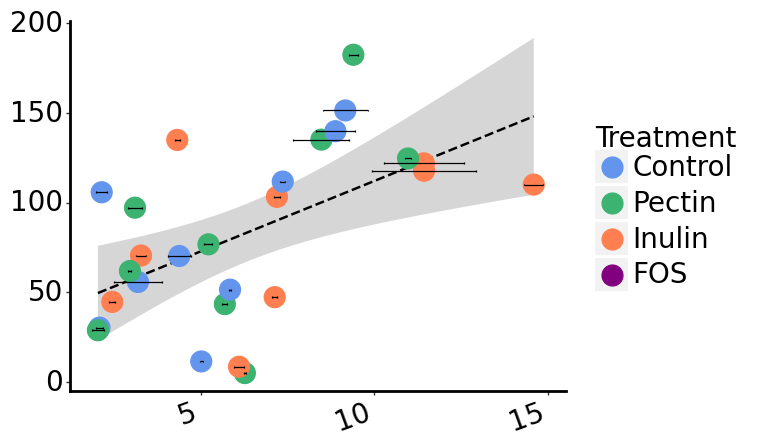

<ggplot: (8760526646315)>

In [346]:
fig2 = (ggplot(
    res, aes(x = 'butyrateMeasured', y = 'butyratePredicted'))
    # +geom_smooth(aes(groups = 'treatment', color = 'treatment'), method = 'lm', linetype = '--')
    +geom_smooth(method = 'lm', linetype = '--')
    +geom_point(aes(color = 'treatment'), size = 8)
    +geom_errorbarh(aes(y = 'butyratePredicted', 
                       xmin = 'butyrateMeasured - butyrateMeasuredSEM',
                       xmax = 'butyrateMeasured + butyrateMeasuredSEM'), height = 1)
    # +geom_rug(aes(color = 'treatment'),sides = 'tr', size = 2)
    +scale_color_manual(limits = ['Control','Pectin','Inulin', 'FOS'], 
                        values = ['cornflowerblue', 'mediumseagreen', 'coral', 'purple'])
    # +scale_fill_manual(limits = ['control','pectin', 'inulin'], 
    #                    values = ['cornflowerblue', 'mediumseagreen', 'coral'])
    +labs(title='',
          x='',
          y = '',
          color = 'Treatment',fill = 'Treatment')
    +theme(text = element_text(size=20, color = 'black'),panel_background=element_rect(fill = "white",
                                    colour = "white",size = 0.5, linetype = "solid"),panel_grid= element_blank(),
                                    axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                    legend_position='right',axis_text_x=element_text(rotation = 20, hjust = 1))
)
fig2

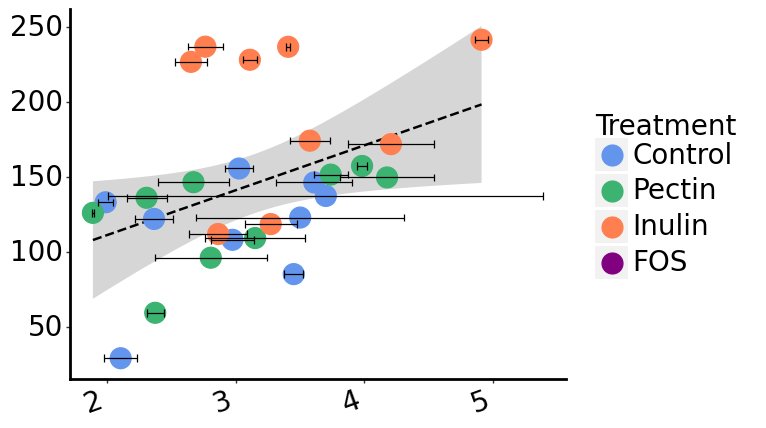

<ggplot: (8760774635502)>

In [347]:
fig3 = (ggplot(
    res, aes(x = 'propionateMeasured', y = 'propionatePredicted'))
    +geom_smooth(method = 'lm', linetype = '--')
    # +geom_smooth(aes(groups = 'treatment', color = 'treatment'), method = 'lm', linetype = '--')
    +geom_point(aes(color = 'treatment'), size = 8)
    +geom_errorbarh(aes(y = 'propionatePredicted', 
                       xmin = 'propionateMeasured - propionateMeasuredSEM',
                       xmax = 'propionateMeasured + propionateMeasuredSEM'), height = 5)
    # +geom_rug(aes(color = 'treatment'),sides = 'tr', size = 2)
    +scale_color_manual(limits = ['Control','Pectin', 'Inulin', 'FOS'], 
                        values = ['cornflowerblue', 'mediumseagreen', 'coral', 'purple'])
    # +scale_fill_manual(limits = ['control','pectin', 'inulin'], 
    #                    values = ['cornflowerblue', 'mediumseagreen', 'coral'])
    +labs(title='',
          x='',
          y = '',
          color = 'Treatment',fill = 'Treatment')
    +theme(text = element_text(size=20, color = 'black'),panel_background=element_rect(fill = "white",
                                    colour = "white",size = 0.5, linetype = "solid"),panel_grid= element_blank(),
                                    axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                    legend_position='right',axis_text_x=element_text(rotation = 20, hjust = 1))
)
fig3

In [349]:
scipy.stats.linregress(res['propionatePredicted'],
                       res['propionateMeasured'])

LinregressResult(slope=0.0056656772689575455, intercept=2.31139404685213, rvalue=0.4121067179562725, pvalue=0.032679248199309355, stderr=0.0025052734857729415, intercept_stderr=0.3867695167013326)

In [240]:
stat_micom, p_micom = scipy.stats.ttest_rel(res[res.treatment.str.contains('control')]['butyratePredicted'],
                      res[res.treatment.str.contains('inulin')]['butyratePredicted'])
stat_exp, p_exp = scipy.stats.ttest_rel(res[res.treatment.str.contains('control')]['butyrateMeasured'],
                      res[res.treatment.str.contains('inulin')]['butyrateMeasured'])
print('MICOM:'+str(p_micom))
print('Experimental:'+str(p_exp))

MICOM:nan
Experimental:nan


In [ ]:
ggsave(fig1,'/users/nbohmann/studyBac.png', dpi = 300)
ggsave(fig2,'/users/nbohmann/studyBbut.png', dpi = 300)
ggsave(fig3,'/users/nbohmann/studyBppa.png', dpi = 300)

In [350]:
res.to_csv('/proj/gibbons/nbohmann/exvivo/gut_puzzle/studyD.csv')

In [256]:
mediumCSV.drop_duplicates(subset = 'reaction')

,Unnamed: 0,reaction,metabolite,global_id,flux,name,molecular_weight,C_number,N_number,hmdb,inchi,kegg.compound,pubchem.compound,chebi,C_flux
EX_ac_m,1.0,EX_ac_m,ac_m,EX_ac(e),0.056450,acetate,59.04402,2.0,0.0,HMDB00042,"InChI=1S/C2H4O2/c1-2(3)4/h1H3,(H,3,4)/p-1",C00033,176.0,NaN,1.129008
EX_acgam_m,2.0,EX_acgam_m,acgam_m,EX_acgam(e),0.010000,N-acetyl-D-glucosamine,221.20780,8.0,1.0,HMDB00215,InChI=1S/C8H15NO6/c1-4(12)9-5(2-10)7(14)8(15)6...,C00140,439174.0,NaN,0.800000
EX_ala_D_m,3.0,EX_ala_D_m,ala_D_m,EX_ala_D(e),0.010000,D-alanine,89.09318,3.0,1.0,HMDB01310,"InChI=1S/C3H7NO2/c1-2(4)3(5)6/h2H,4H2,1H3,(H,5...",C00133,71080.0,NaN,0.300000
EX_ala_L_m,4.0,EX_ala_L_m,ala_L_m,EX_ala_L(e),0.094786,L-alanine,89.09318,3.0,1.0,HMDB00161,"InChI=1S/C3H7NO2/c1-2(4)3(5)6/h2H,4H2,1H3,(H,5...",C00041,5950.0,NaN,2.843580
EX_amet_m,5.0,EX_amet_m,amet_m,EX_amet(e),0.010000,S-Adenosyl-L-methionine,399.44532,15.0,6.0,HMDB01185,NaN,C00019,34756.0,NaN,1.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EX_strch1_m,NaN,EX_strch1_m,strch1_m,NaN,20.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EX_strch2_m,NaN,EX_strch2_m,strch2_m,NaN,20.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EX_starch1200_m,NaN,EX_starch1200_m,starch1200_m,NaN,0.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EX_dextrin_m,NaN,EX_dextrin_m,dextrin_m,NaN,20.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [289]:
mediumNotebook.sort_values(by = 'metabolite', inplace = True)
mediumCSV.sort_values(by = 'metabolite', inplace = True)

In [280]:
diff = mediumCSV['flux'] - mediumNotebook['flux']

In [290]:
mediumCSV['flux'] = mediumNotebook.flux

In [287]:
mediumNotebook

,Unnamed: 0,reaction,metabolite,global_id,flux,name,molecular_weight,C_number,N_number,hmdb,inchi,kegg.compound,pubchem.compound,chebi,C_flux
reaction,,,,,,,,,,,,,,,
EX_alagln_m,207.0,EX_alagln_m,alagln_m,EX_alagln(e),0.000004,L-alanyl-L-glutamine,217.222400,8.0,3.0,NaN,NaN,NaN,NaN,NaN,0.000335
EX_thmmp_m,197.0,EX_thmmp_m,thmmp_m,EX_thmmp(e),0.000008,Thiamin monophosphate,343.318601,12.0,4.0,HMDB02666,NaN,C01081,3382778.0,NaN,0.000953
EX_nadp_m,213.0,EX_nadp_m,nadp_m,EX_nadp(e),0.000008,Nicotinamide adenine dinucleotide phosphate,740.381183,21.0,7.0,HMDB00217,NaN,C00006,5886.0,NaN,0.001667
EX_coa_m,191.0,EX_coa_m,coa_m,EX_coa(e),0.000015,Coenzyme A,763.502363,21.0,7.0,HMDB01423,NaN,C00010,6816.0,NaN,0.003189
EX_dpcoa_m,89.0,EX_dpcoa_m,dpcoa_m,EX_dpcoa(e),0.000016,Dephospho-CoA,685.538342,21.0,7.0,HMDB01373,NaN,C00882,444485.0,NaN,0.003335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EX_meoh_m,137.0,EX_meoh_m,meoh_m,EX_meoh(e),1.000000,methanol,32.041860,1.0,0.0,HMDB01875,"InChI=1S/CH4O/c1-2/h2H,1H3",C00132,887.0,NaN,10.000000
EX_strch1_m,NaN,EX_strch1_m,strch1_m,NaN,20.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EX_strch2_m,NaN,EX_strch2_m,strch2_m,NaN,20.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [231]:
mediumNotebook.loc['EX_pect_m']

KeyError: 'EX_inulin_m'

In [223]:
inulinMedium.loc['EX_inulin_m']

Unnamed: 0                   NaN
reaction             EX_inulin_m
metabolite              inulin_m
global_id           EX_inulin(e)
flux                        14.0
name                         NaN
molecular_weight             NaN
C_number                     NaN
N_number                     NaN
hmdb                         NaN
inchi                        NaN
kegg.compound                NaN
pubchem.compound             NaN
chebi                        NaN
C_flux                       NaN
Name: EX_inulin_m, dtype: object